# cis-eQTL analysis
- Explore gene length

After nominal pass:
- Determine optimal #HCP from nominal associations
- Visualize expression regressed by covariates, check batch effect
- Maybe: Relative log-expression RLE plots

After permutation pass:
- check beta approximated permutation pval
- QTL TSS distance density plot
- Compare sig feature across ancestries, upsetR
- Venn graph for fetal vs PEC, GTEx
- eGene types (protein_coding, lnc, etc.)
- Conditional pass

In [4]:
suppressMessages(library(ggplot2))
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(tidyr))
suppressMessages(library(VennDiagram))
suppressMessages(library(UpSetR))

### 0: Explore gene length. Is 1Mb cis window good?

In [2]:
dat <- fread("data/gene.counts.processed.tsv", data.table = F)

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/gene.counts.processed.tsv", :
“Detected 642 column names but the data has 643 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [20]:
gencode <- fread("~/project-gandalm/isoform_twas/salmon/gencode.gene.noVersion.tsv", data.table = F)

In [4]:
head(dat)

,V1,1474,1496,1500,1502,1507,1511,1513,1525,1531,⋯,1558,1607,1707.1,1835,1851,1890,1923,2193,849,898
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000419,9.841250,9.177032,9.470526,8.889949,8.859147,9.869163,9.518204,9.473462,9.167232,⋯,9.313513,9.641778,9.103888,10.016891,9.717624,8.875114,9.177785,8.908476,8.818348,8.781627
2,ENSG00000000457,9.240075,9.345108,9.409079,9.360622,9.364026,9.298172,9.307230,9.450109,8.744793,⋯,9.248521,9.034432,8.909848,9.451742,8.936577,8.905937,9.151401,9.047019,9.203484,8.959639
3,ENSG00000000460,9.958170,8.602040,9.494180,8.527582,8.842721,9.494976,8.963676,8.468142,8.140846,⋯,8.492937,8.813609,8.058658,9.023049,8.393364,8.574984,8.375750,8.231860,8.295203,7.960872
4,ENSG00000000938,3.785048,4.625944,4.389944,4.436550,5.329249,4.997359,4.236019,5.190552,3.709355,⋯,4.571956,6.526651,4.429746,4.292569,5.237749,4.572319,4.983927,4.248742,5.407510,5.803780
5,ENSG00000000971,6.613001,7.545237,7.117006,5.820229,8.248171,6.480063,8.364863,7.103860,5.862169,⋯,6.175374,10.131938,8.967814,6.368925,9.193750,9.434200,8.454724,8.998835,7.558015,9.445345
6,ENSG00000001036,8.293299,8.657986,8.622531,7.847619,8.547067,8.458103,8.107981,8.436925,8.011778,⋯,8.184961,8.792488,8.580463,8.514031,8.656127,8.288406,8.255862,8.481300,8.437080,8.845259


In [5]:
head(gencode)

,V1,V2,V3,V4,V5
,<chr>,<int>,<int>,<chr>,<chr>
1,chr1,11869,14409,+,ENSG00000223972
2,chr1,14404,29570,-,ENSG00000227232
3,chr1,29554,31109,+,ENSG00000243485
4,chr1,34554,36081,-,ENSG00000237613
5,chr1,52473,53312,+,ENSG00000268020
6,chr1,57598,64116,+,ENSG00000240361


In [6]:
dim(gencode)

[1] 62486     5

In [21]:
gencode <- gencode %>% filter(V5 %in% dat$V1)
dim(gencode)

[1] 31947     5

In [22]:
gencode <- gencode %>% mutate(length=V3-V2)
head(gencode)

,V1,V2,V3,V4,V5,length
,<chr>,<int>,<int>,<chr>,<chr>,<int>
1,chr1,11869,14409,+,ENSG00000223972,2540
2,chr1,14404,29570,-,ENSG00000227232,15166
3,chr1,29554,31109,+,ENSG00000243485,1555
4,chr1,34554,36081,-,ENSG00000237613,1527
5,chr1,89295,133723,-,ENSG00000238009,44428
6,chr1,89551,91105,-,ENSG00000239945,1554


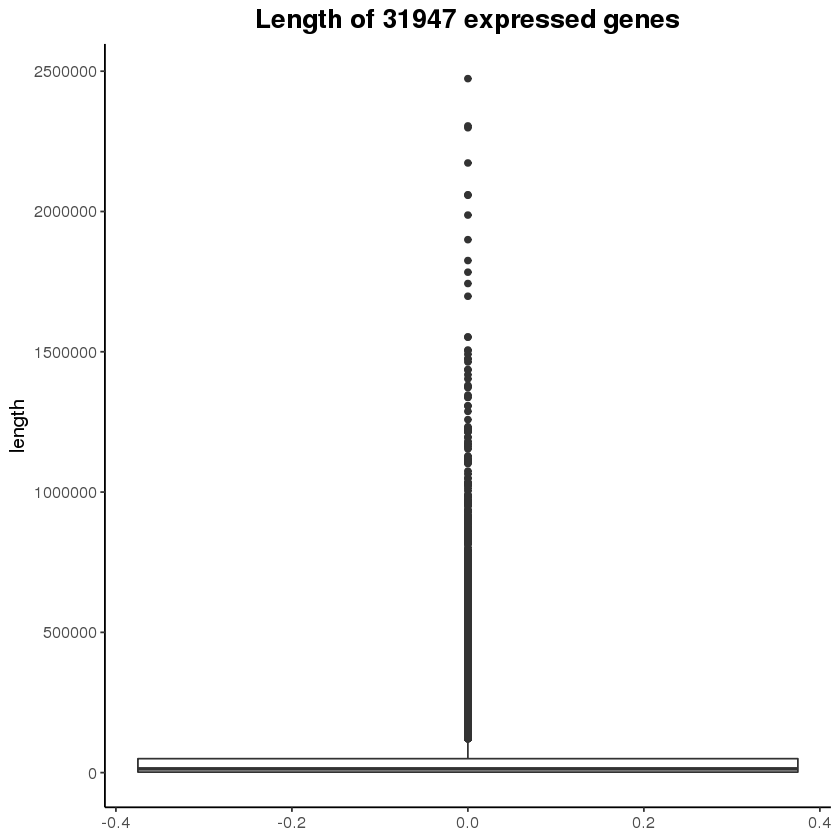

In [14]:
p <- ggplot(gencode, aes(y=length)) +
#     geom_density(color="black") +
    geom_boxplot() +
    labs(title = "Length of 31947 expressed genes") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p

In [23]:
range(gencode$length)

[1]      51 2473539

In [17]:
gencode[gencode$length==2473539,]

,V1,V2,V3,V4,V5,length
,<chr>,<int>,<int>,<chr>,<chr>,<int>
24149,chr16,5289803,7763342,+,ENSG00000078328,2473539


In [24]:
sum(gencode$length > 1000000)

[1] 74

In [25]:
gencode %>% filter(length > 1000000)

V1,V2,V3,V4,V5,length
<chr>,<int>,<int>,<chr>,<chr>,<int>
chr1,14219287,15444539,+,ENSG00000189337,1225252
chr1,48998526,50489626,-,ENSG00000186094,1491100
chr1,57460451,59012406,-,ENSG00000173406,1551955
chr1,88086486,89150887,-,ENSG00000237505,1064401
chr2,33931953,34963298,+,ENSG00000228262,1031345
chr2,50145641,51452713,-,ENSG00000179915,1307072
chr2,51259739,52635055,+,ENSG00000231918,1375316
chr2,79412357,80875986,+,ENSG00000066032,1463629
chr2,115199876,116603356,+,ENSG00000175497,1403480


### 1: Optimal number of HCP

#### Mixed ancestry

In [2]:
df <- data.frame("HCP" = seq(10, 100, 10),
                 "Count" = NA)
for (i in seq(10, 100, 10)) {
    df[i/10, "Count"] <- read.table(paste0("results/mixed_nominal_", i, 
                                           "hcp/significant_feature_count.txt"))[,1]
}

In [3]:
df

HCP,Count
<dbl>,<int>
10,19669
20,21267
30,21839
40,22320
50,22648
60,22671
70,22736
80,22830
90,22850


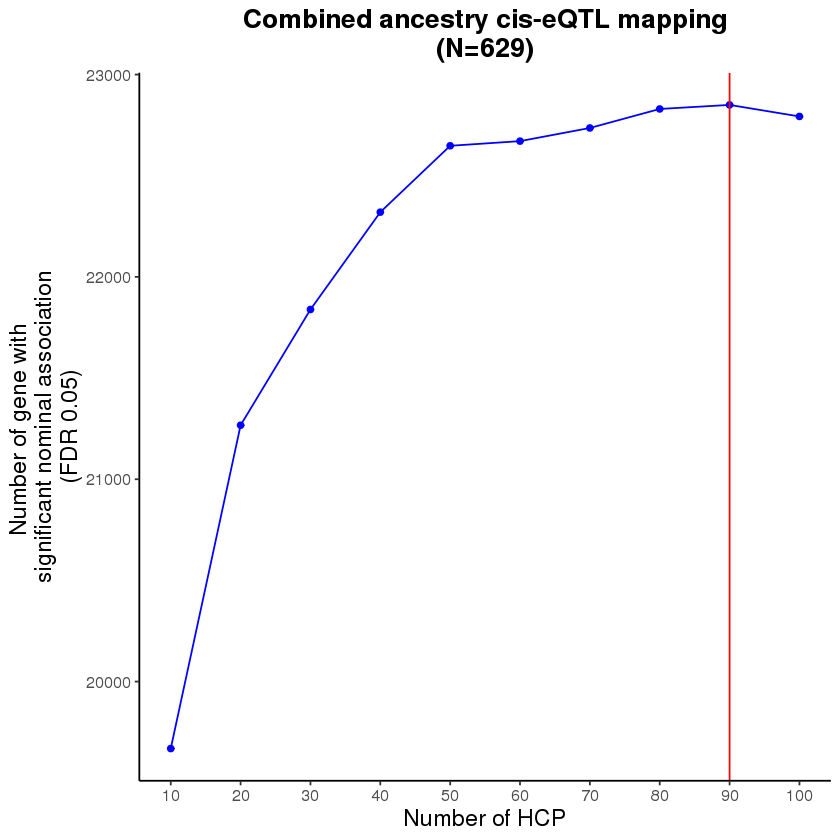

In [5]:
p1 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "blue") +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,110,by = 10)) +
    geom_vline(xintercept = 90, color = "red") +
    labs(title = "Combined ancestry cis-eQTL mapping\n(N=629)",
         x = "Number of HCP",
         y = "Number of gene with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p1

In [6]:
ggsave("figures/mixed_nominal.png", p1, width = 6, height = 6)

#### EUR

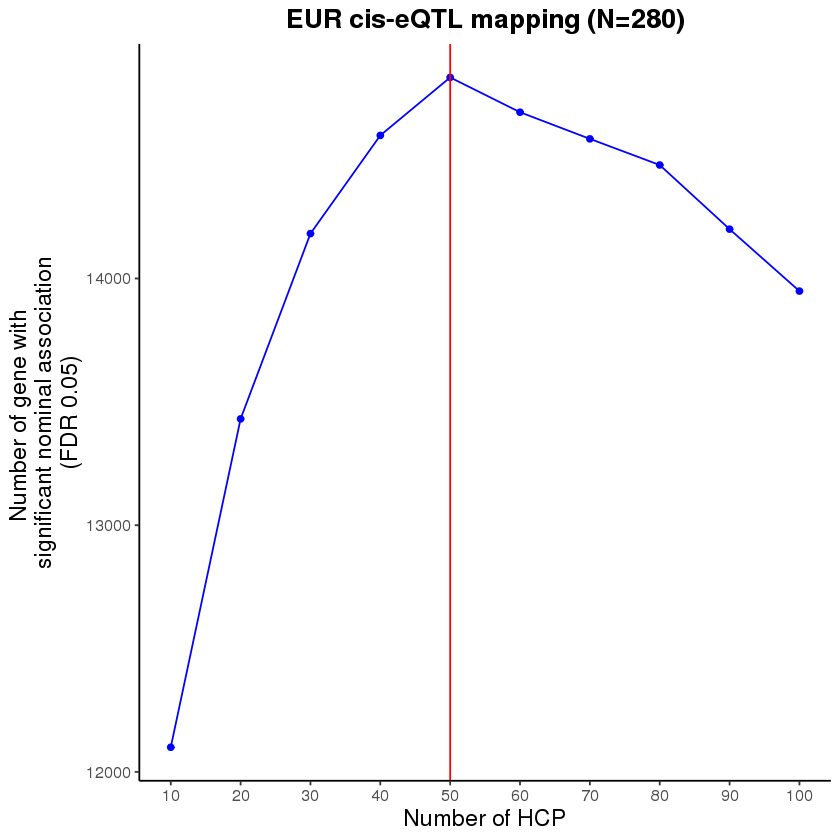

In [2]:
df <- data.frame("HCP" = seq(10, 100, 10),
                 "Count" = NA)
for (i in seq(10, 100, 10)) {
    df[i/10, "Count"] <- read.table(paste0("results/eur_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p3 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "blue") +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,110,by = 10)) +
    geom_vline(xintercept = 50, color = "red") +
    labs(title = "EUR cis-eQTL mapping (N=280)",
         x = "Number of HCP",
         y = "Number of gene with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p3

In [3]:
ggsave("figures/eur_nominal.png", p3, width = 6, height = 6)

#### AMR

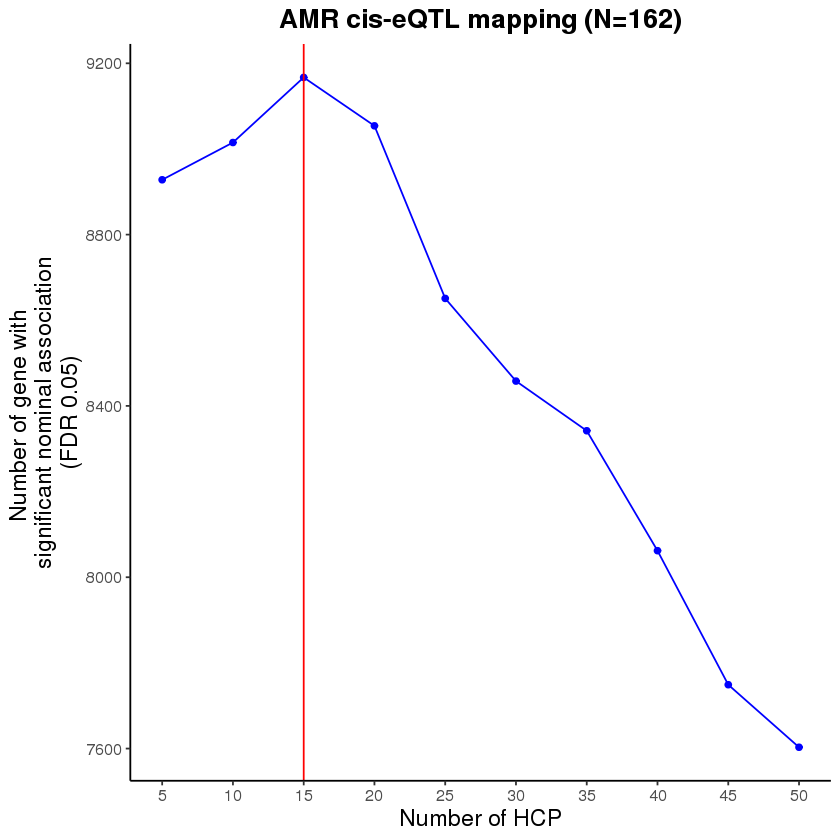

In [4]:
df <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df[i/5, "Count"] <- read.table(paste0("results/amr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p4 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "blue") +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,55,by = 5)) +
    geom_vline(xintercept = 15, color = "red") +
    labs(title = "AMR cis-eQTL mapping (N=162)",
         x = "Number of HCP",
         y = "Number of gene with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p4

In [5]:
ggsave("figures/amr_nominal.png", p4, width = 6, height = 6)

#### AFR

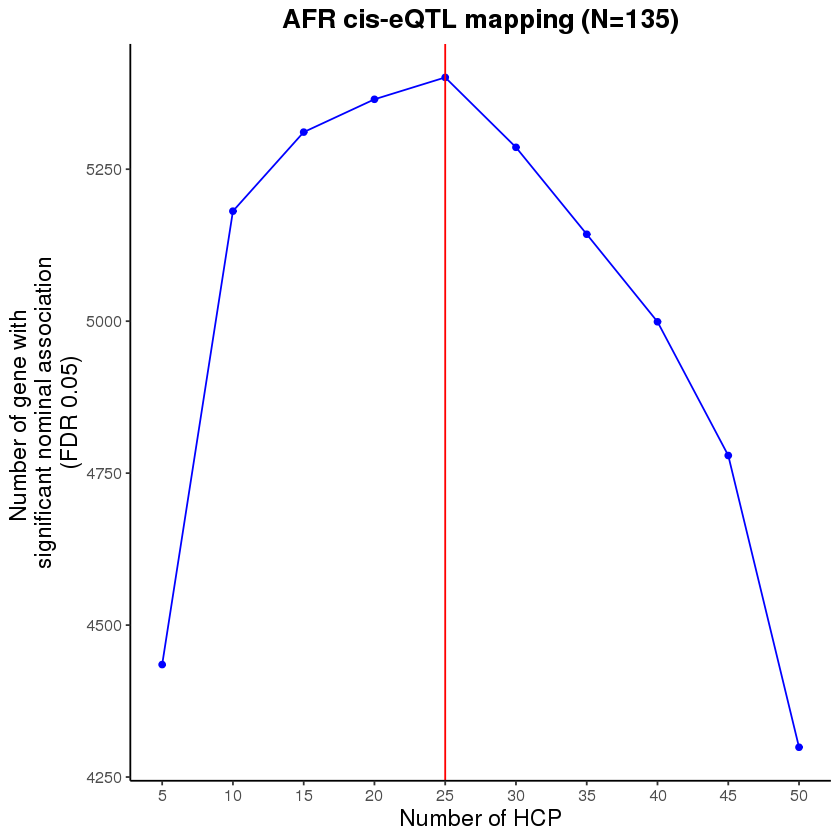

In [7]:
df <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df[i/5, "Count"] <- read.table(paste0("results/afr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p5 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "blue") +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,55,by = 5)) +
    geom_vline(xintercept = 25, color = "red") +
    labs(title = "AFR cis-eQTL mapping (N=135)",
         x = "Number of HCP",
         y = "Number of gene with \nsignificant nominal association\n(FDR 0.05)") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
          axis.title = element_text(size=14),
          plot.title = element_text(size=16, face="bold", hjust = 0.5))
p5

In [8]:
ggsave("figures/afr_nominal.png", p5, width = 6, height = 6)

### 2: Gene expression regression, check batch effects

#### Mixed ancestry

In [7]:
datExpr <- fread("data/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/gene.counts.processed.tsv", :
“Detected 642 column names but the data has 643 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [8]:
datExpr_noCombat <- fread("data/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/gene.counts.processed.noComBat.tsv", :
“Detected 642 column names but the data has 643 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [9]:
cov <- read.table("data/90hcp_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

In [10]:
# remove related
rel <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/related.txt", header = F, stringsAsFactors = F)[,1]
rel

[1] "1614"   "11602"  "Br1779" "Br2394" "Br2402" "Br2411" "Br2412" "1713"  
 [9] "11841"  "Br1794" "HSB148" "HSB107" "HSB154" "HSB100"

In [10]:
head(cov)

,1474,1496,1500,1502,1507,1511,1513,1525,1531,1533,⋯,1558,1607,1707.1,1835,1851,1890,1923,2193,849,898
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
PC1,0.00898199,-0.0076338,0.0111147,0.00487142,0.00960893,-0.01488,0.00883737,-0.0266981,-0.0253829,0.00976202,⋯,0.00967447,-0.0252683,0.00965381,0.00960237,0.00979039,0.00950035,0.00960529,0.00989866,0.00702467,0.00983834
PC2,-0.00035727,-0.000843408,-0.0158545,0.000257063,-0.00326613,-0.00113582,-0.00241496,-0.0022033,-0.00247448,-0.0043343,⋯,-0.0208489,-0.00395539,-0.0206395,-0.0210822,-0.0204132,-0.0205727,-0.0206059,-0.0210826,0.0245783,-0.0205709
PC3,-0.0248268,-0.0141886,-0.0101601,-0.0222758,-0.020871,-0.00907471,-0.021557,-0.00118133,-0.00152521,-0.0192131,⋯,-0.00482939,-0.00111922,-0.00453659,-0.00526304,-0.00508921,-0.00534413,-0.00518309,-0.00544843,-0.00538244,-0.00537699
PC4,-0.0321383,-0.0175555,-0.000733046,-0.0315899,-0.0245335,-0.0106596,-0.0266302,0.000414128,0.000549499,-0.0225191,⋯,0.0229196,0.0138587,0.0222114,0.0226635,0.0214958,0.0226123,0.0221212,0.0239712,0.0252937,0.0216689
PC5,0.000571238,-0.00167298,-0.0126722,0.00128243,-0.00225702,-0.00145859,-0.00174134,-0.00474446,-0.00445944,-0.0030688,⋯,0.0685564,0.0750816,0.0672512,0.0693604,0.0685406,0.06972,0.0690513,0.0679772,0.0693614,0.0681412
sex,M,F,M,M,M,M,M,M,F,M,⋯,F,F,F,M,F,F,F,M,F,F


In [11]:
cov <- cov[,!names(cov) %in% rel]
dim(cov)

[1]  97 629

In [12]:
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

[1] 31947   629

[1] 31947   629

In [13]:
cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

In [14]:
cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

In [15]:
walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

In [16]:
# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

In [17]:
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

In [18]:
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

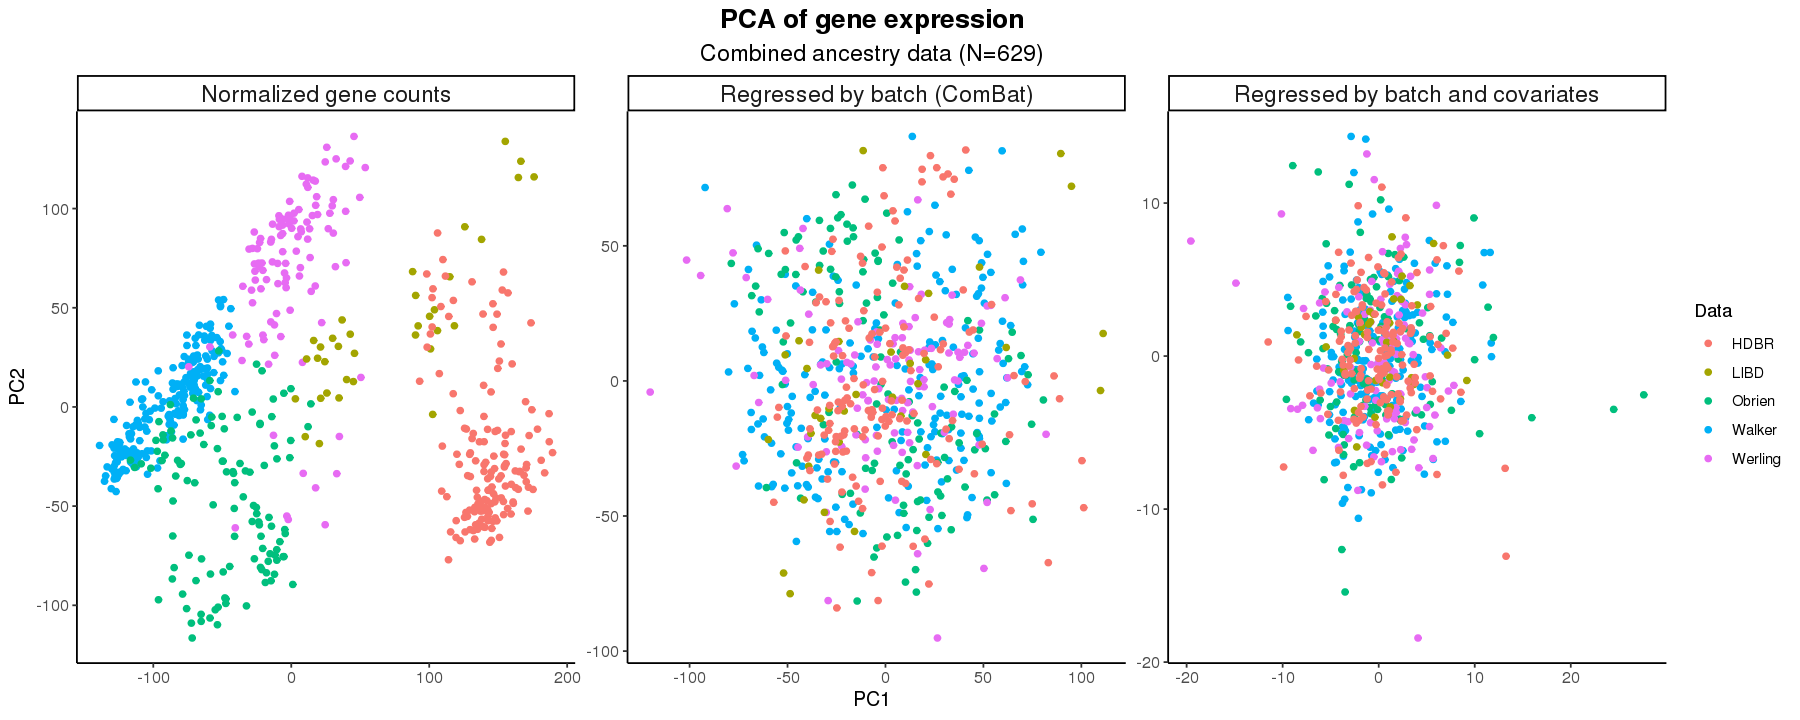

In [19]:
options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p2 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of gene expression",
       subtitle = "Combined ancestry data (N=629)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p2

In [20]:
ggsave("figures/mixed_regress.png", p2, width = 15, height = 6)

#### EUR

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/eur/gene.counts.processed.tsv", :
“Detected 284 column names but the data has 285 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/eur/gene.counts.processed.noComBat.tsv", :
“Detected 284 column names but the data has 285 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  57 280

[1] 31947   280

[1] 31947   280

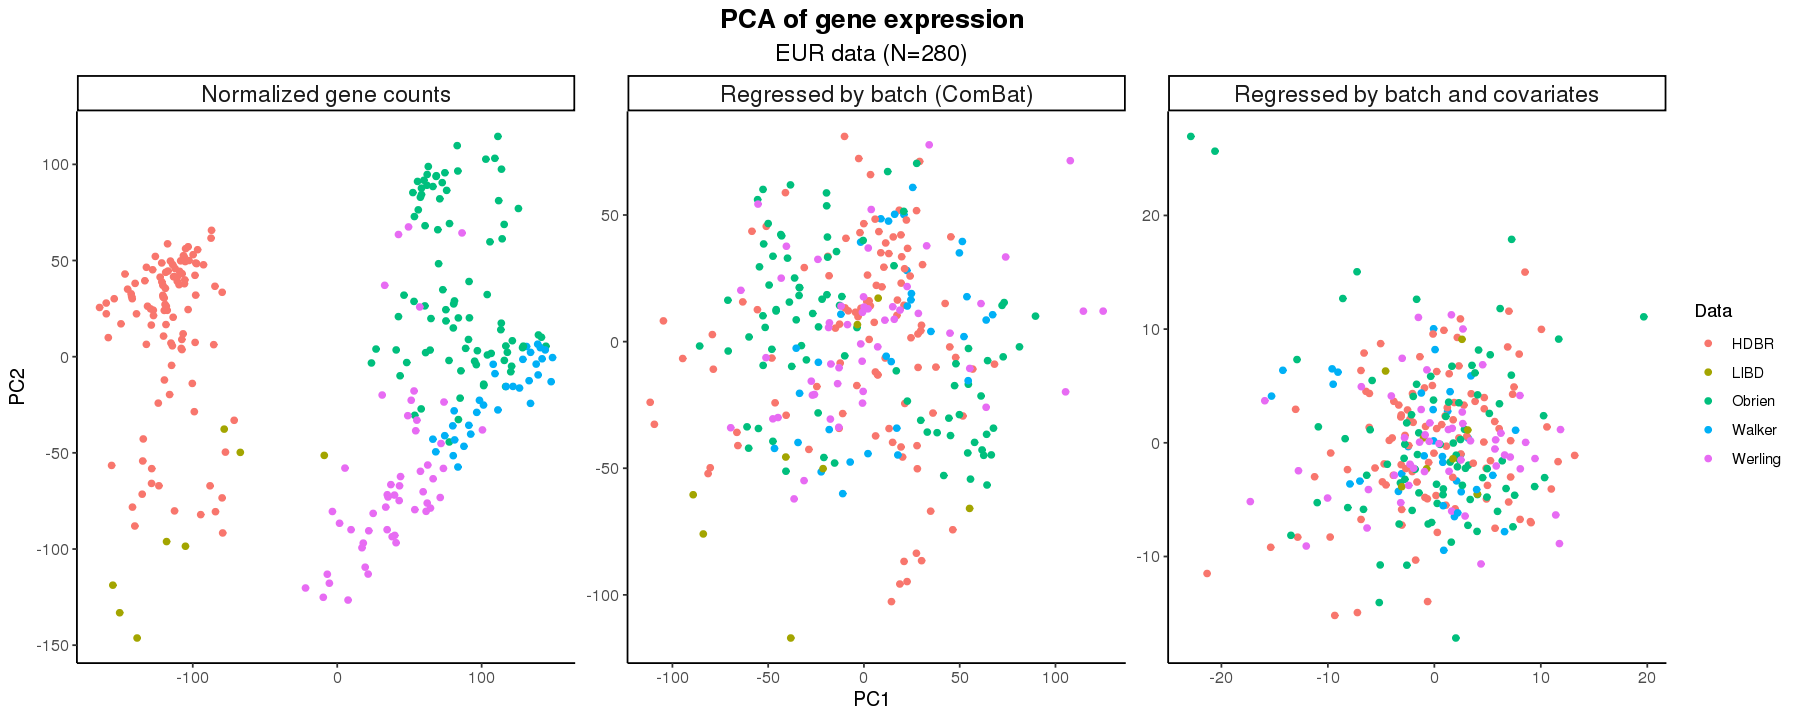

In [10]:
datExpr <- fread("data/eur/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/eur/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/eur/50HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p6 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of gene expression",
       subtitle = "EUR data (N=280)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p6

In [11]:
ggsave("figures/eur_regress.png", p6, width = 15, height = 6)

#### AMR

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/amr/gene.counts.processed.tsv", :
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/amr/gene.counts.processed.noComBat.tsv", :
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  22 162

[1] 31947   162

[1] 31947   162

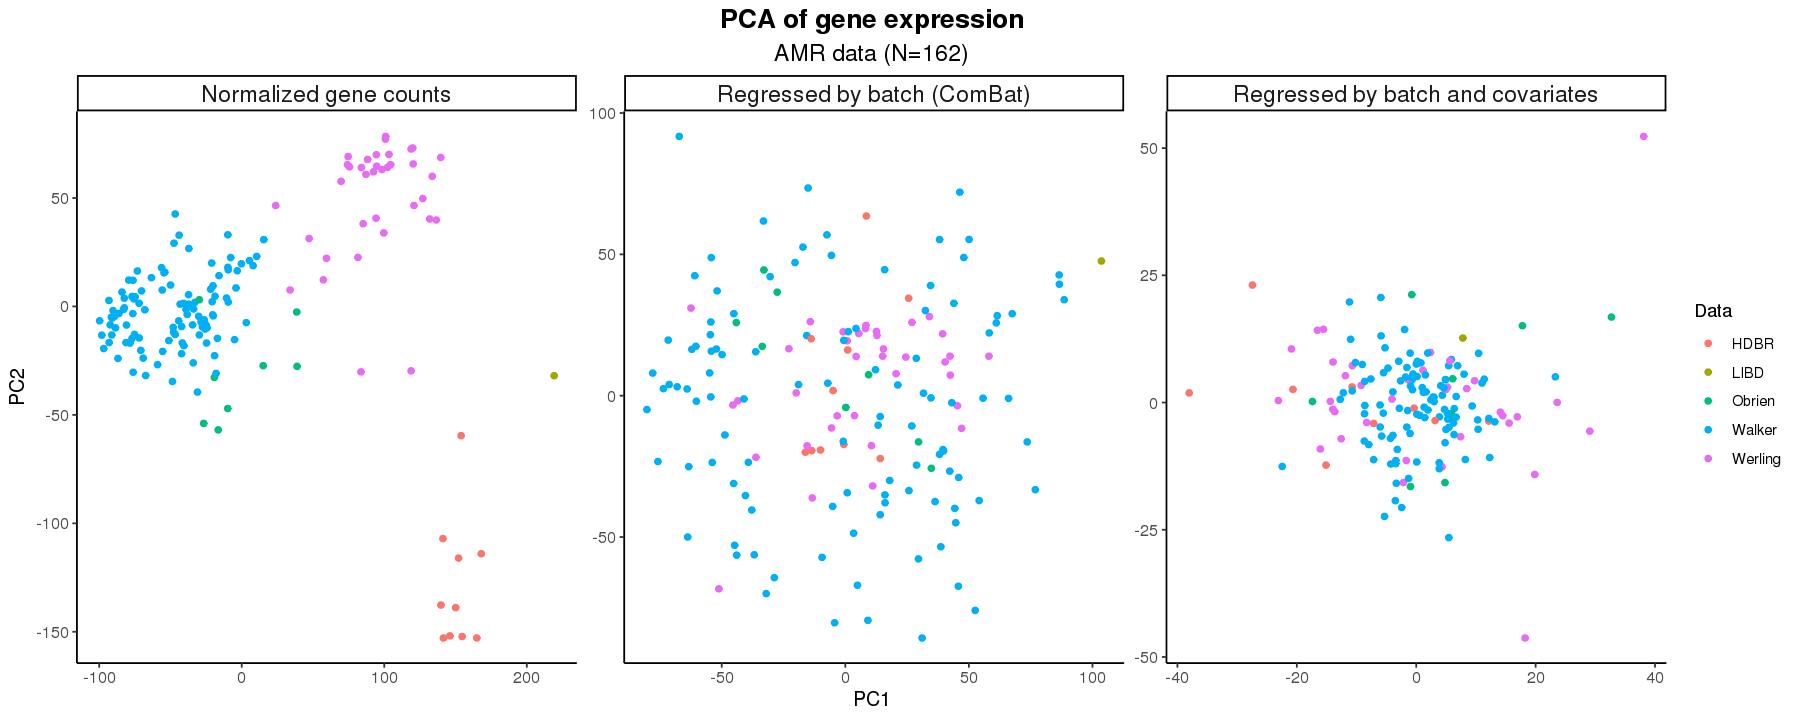

In [13]:
datExpr <- fread("data/amr/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/amr/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/amr/15HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

# walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
# obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
# werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
# hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
# libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p7 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of gene expression",
       subtitle = "AMR data (N=162)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p7

ggsave("figures/amr_regress.png", p7, width = 15, height = 6)

#### AFR

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/afr/gene.counts.processed.tsv", :
“Detected 142 column names but the data has 143 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/afr/gene.counts.processed.noComBat.tsv", :
“Detected 142 column names but the data has 143 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  32 135

[1] 31947   135

[1] 31947   135

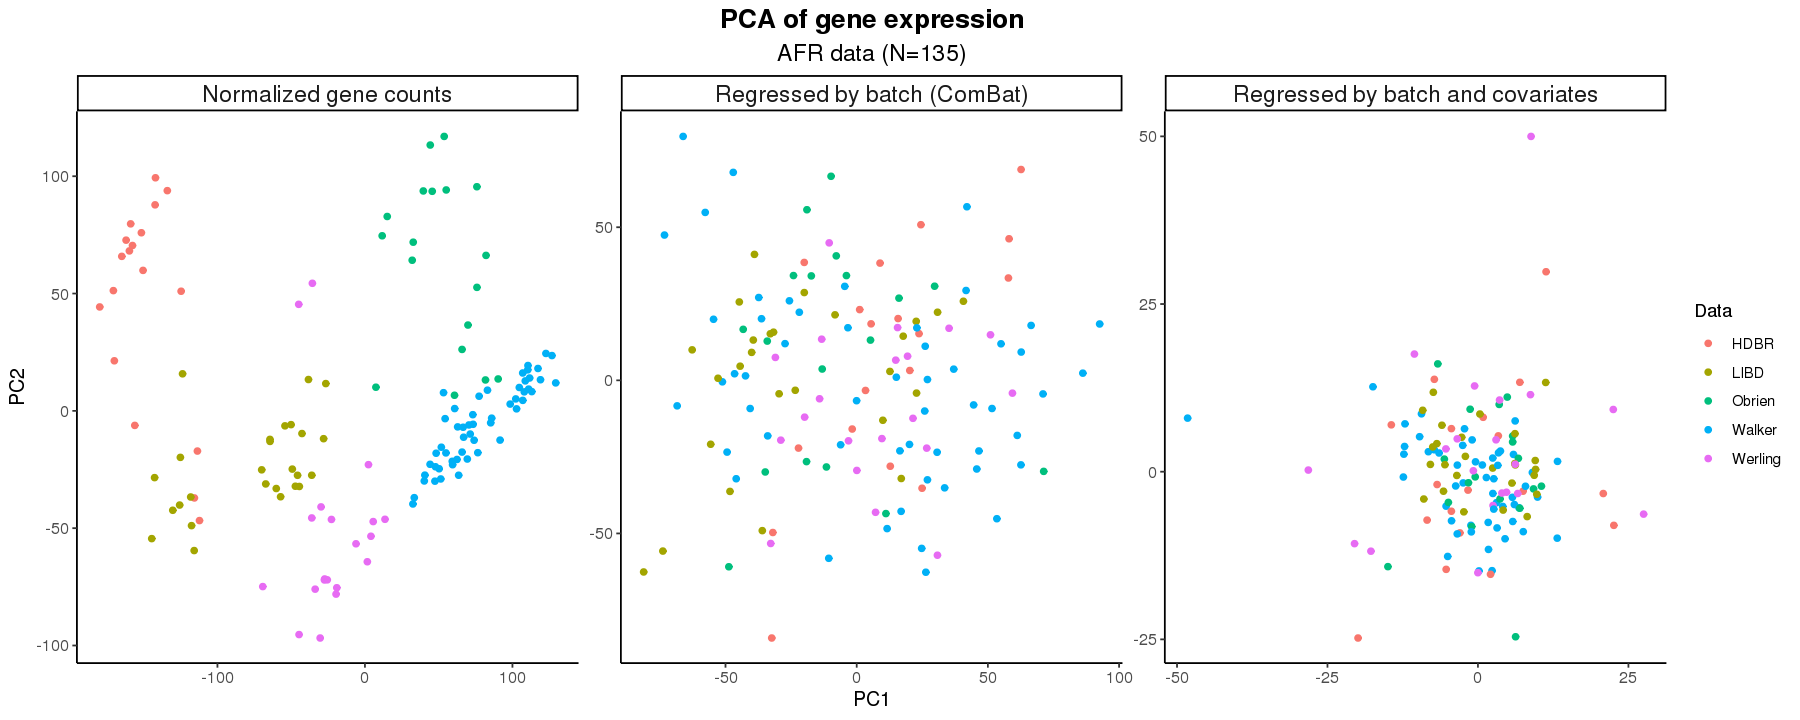

In [14]:
datExpr <- fread("data/afr/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/afr/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/afr/25HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

# walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
# obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
# werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
# hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
# libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p8 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "PC1", y = "PC2", 
       title = "PCA of gene expression",
       subtitle = "AFR data (N=135)") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5),
        strip.text.x = element_text(size=14))
p8

ggsave("figures/afr_regress.png", p8, width = 15, height = 6)

### 3: Check beta-approximated permutation pval

In [21]:
mixed <- fread("results/mixed_perm_90hcp/all.chunks.txt.gz", data.table=F)
colnames(mixed) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")

In [22]:
mixed <- mixed[complete.cases(mixed),]
mixed <- arrange(mixed, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()

In [23]:
round(cor(mixed[, 'ppval'], mixed[, 'bpval']), 4)

[1] 0.9999

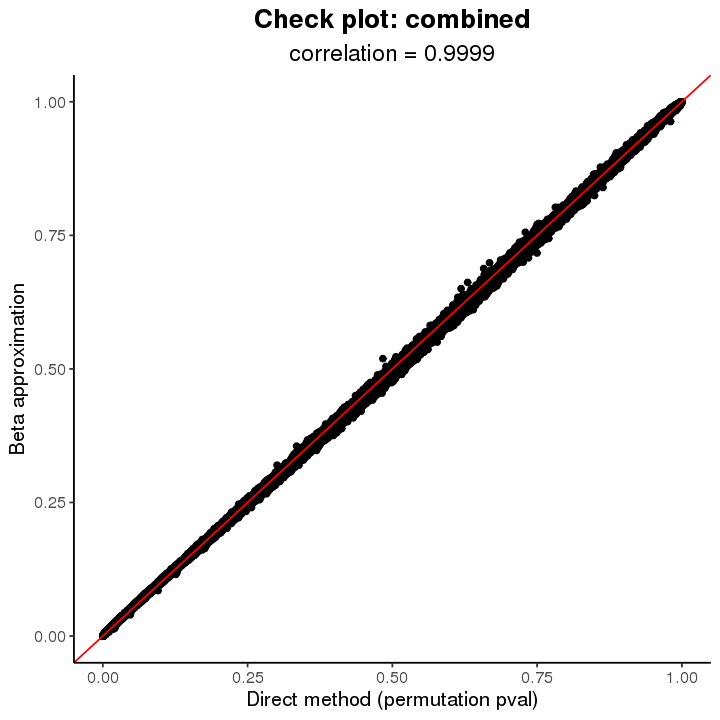

In [25]:
options(repr.plot.width=6, repr.plot.height=6)
p <- ggplot(mixed, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: combined",
         subtitle = "correlation = 0.9999") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p

In [26]:
ggsave("figures/mixed_check.png", p, width = 6, height = 6)

[1] 0.9998

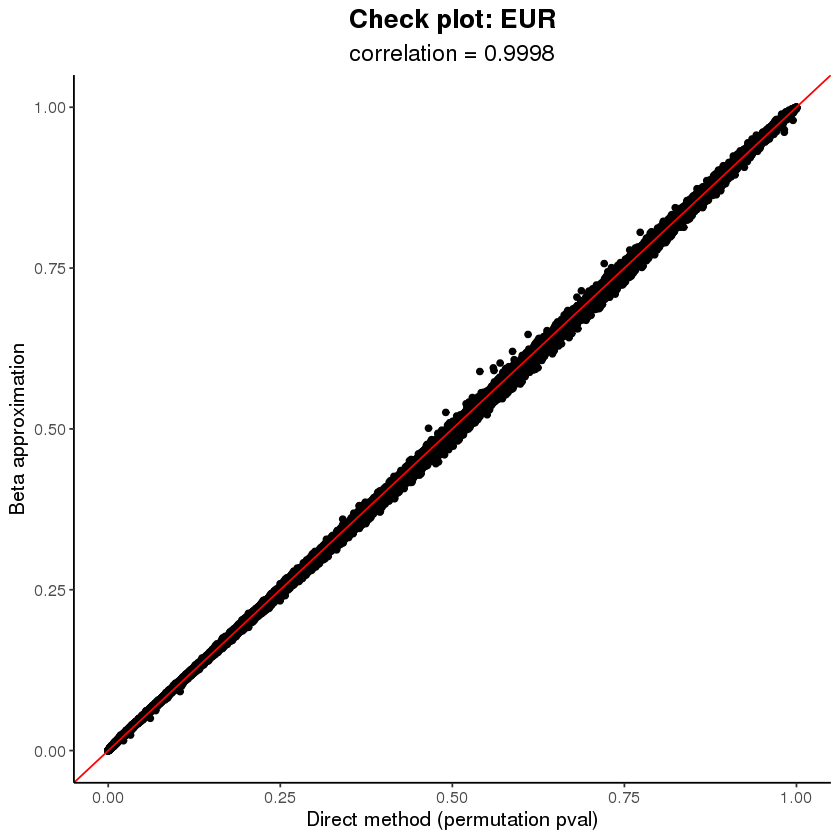

In [10]:
eur <- fread("results/eur_perm_50HCP/all.chunks.txt.gz", data.table=F)
colnames(eur) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
eur <- eur[complete.cases(eur),]
eur <- arrange(eur, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
round(cor(eur[, 'ppval'], eur[, 'bpval']), 4)

p1 <- ggplot(eur, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: EUR",
         subtitle = "correlation = 0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p1
ggsave("figures/eur_check.png", p1, width = 6, height = 6)

[1] 0.9998

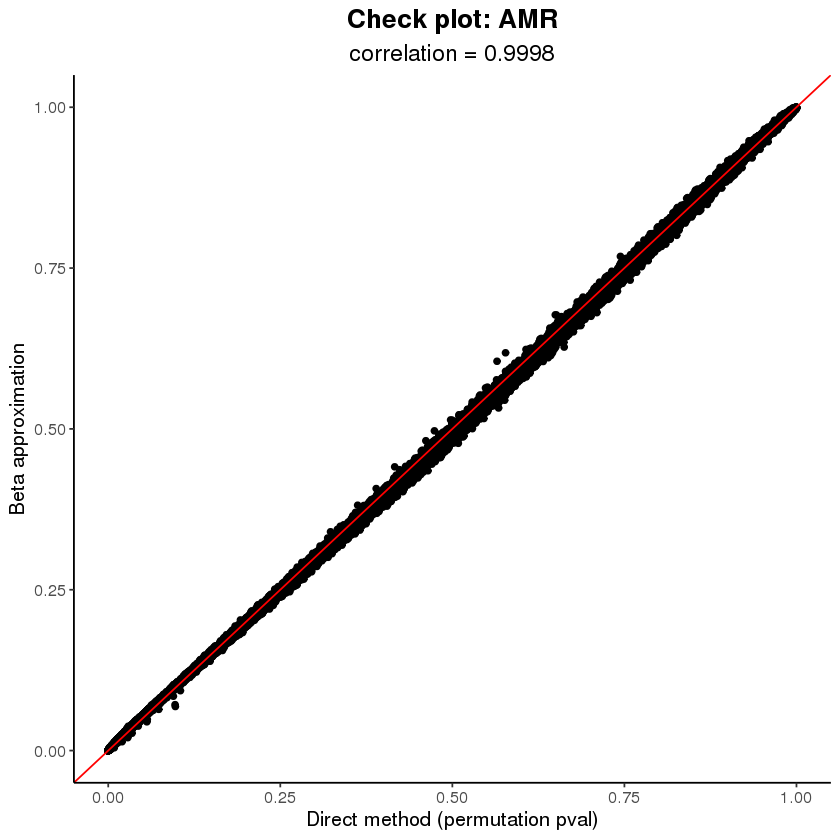

In [11]:
amr <- fread("results/amr_perm_15HCP/all.chunks.txt.gz", data.table=F)
colnames(amr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
amr <- amr[complete.cases(amr),]
amr <- arrange(amr, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
round(cor(amr[, 'ppval'], amr[, 'bpval']), 4)
p2 <- ggplot(amr, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: AMR",
         subtitle = "correlation = 0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p2
ggsave("figures/amr_check.png", p2, width = 6, height = 6)

[1] 0.9998

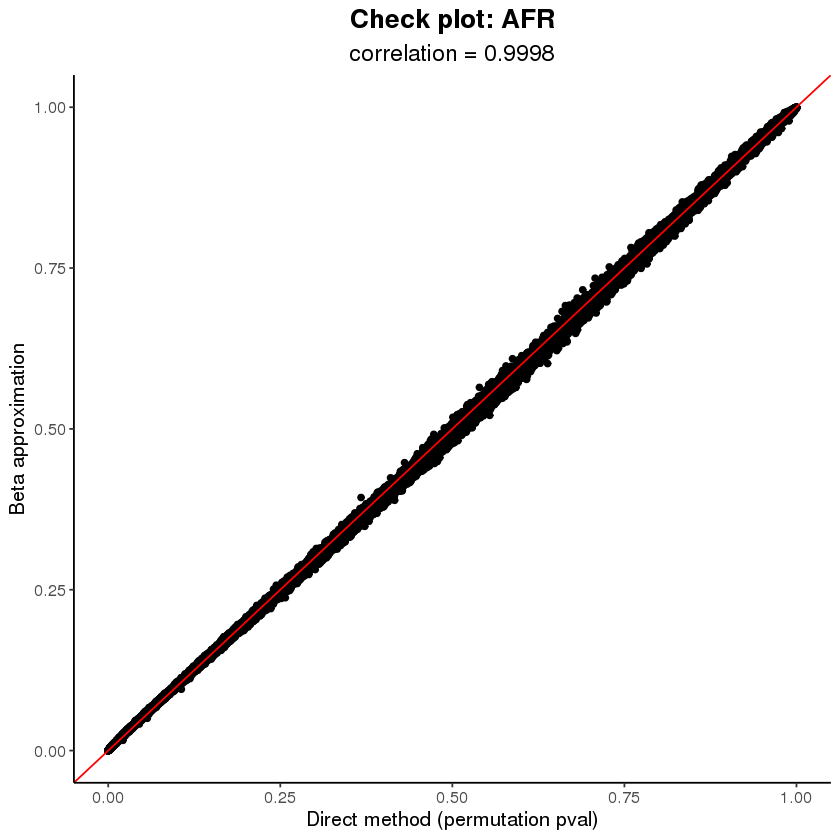

In [13]:
afr <- fread("results/afr_perm_25HCP/all.chunks.txt.gz", data.table=F)
colnames(afr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
afr <- afr[complete.cases(afr),]
afr <- arrange(afr, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
round(cor(afr[, 'ppval'], afr[, 'bpval']), 4)

p3 <- ggplot(afr, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "Direct method (permutation pval)",
         y = "Beta approximation",
         title = "Check plot: AFR",
         subtitle = "correlation = 0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p3
ggsave("figures/afr_check.png", p3, width = 6, height = 6)

### 4: dTSS of top eQTL

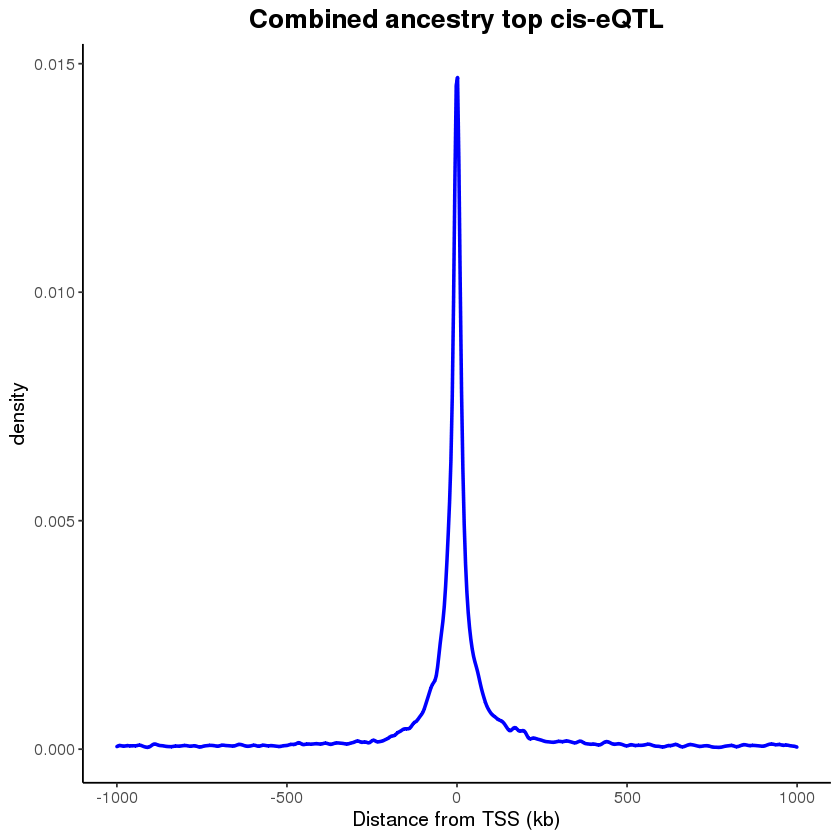

In [9]:
mixed_sig <- read.table("results/mixed_perm_90hcp/sig_pheno.txt", header = T, stringsAsFactors = F)
mixed_sig$dist_kb <- mixed_sig$dist/1000
p <- ggplot(mixed_sig, aes(x = dist_kb)) +
    geom_density(color = "blue", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "Combined ancestry top cis-eQTL") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p

In [28]:
ggsave("figures/mixed_dist.png", p, height = 6, width = 6)

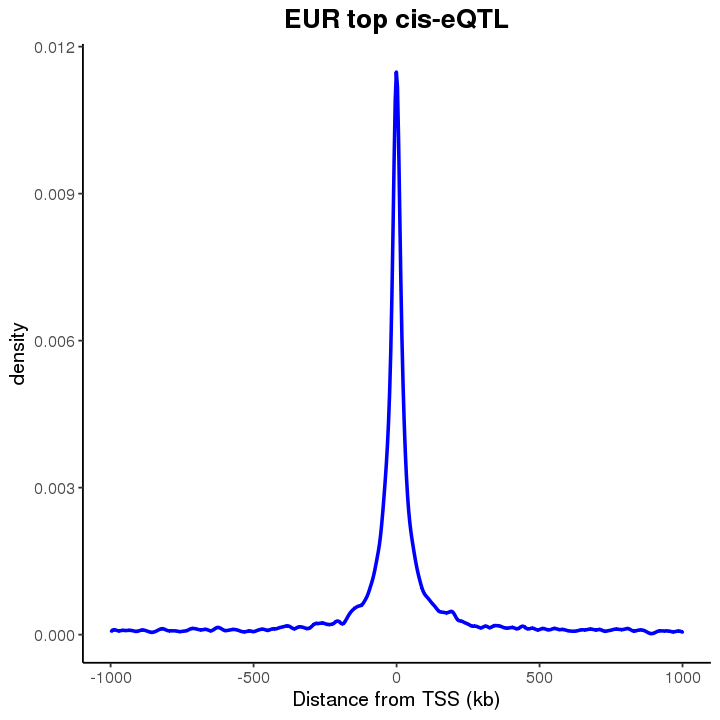

In [29]:
eur_sig <- read.table("results/eur_perm_50HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
eur_sig$dist_kb <- eur_sig$dist/1000
p1 <- ggplot(eur_sig, aes(x = dist_kb)) +
    geom_density(color = "blue", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "EUR top cis-eQTL") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p1
ggsave("figures/eur_dist.png", p1, height = 6, width = 6)

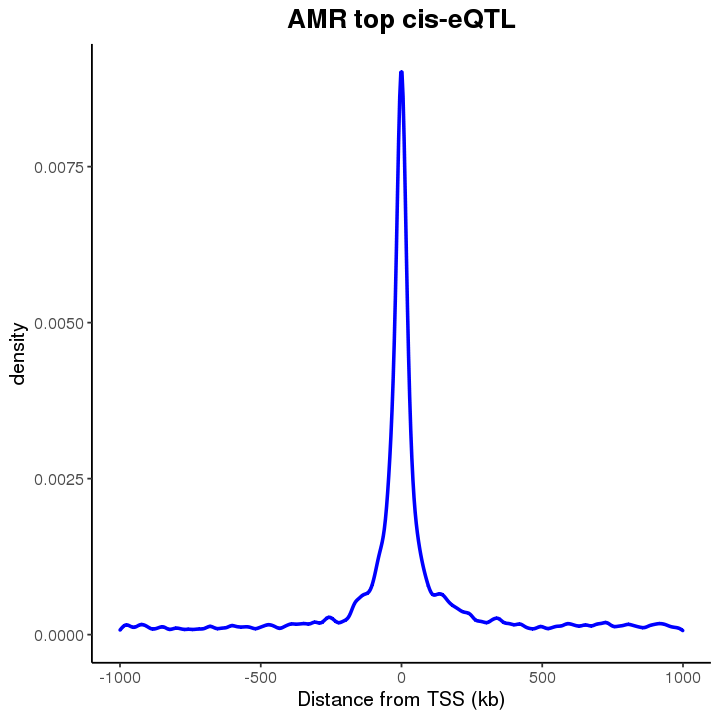

In [30]:
amr_sig <- read.table("results/amr_perm_15HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
amr_sig$dist_kb <- amr_sig$dist/1000
p2 <- ggplot(amr_sig, aes(x = dist_kb)) +
    geom_density(color = "blue", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "AMR top cis-eQTL") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p2
ggsave("figures/amr_dist.png", p2, height = 6, width = 6)

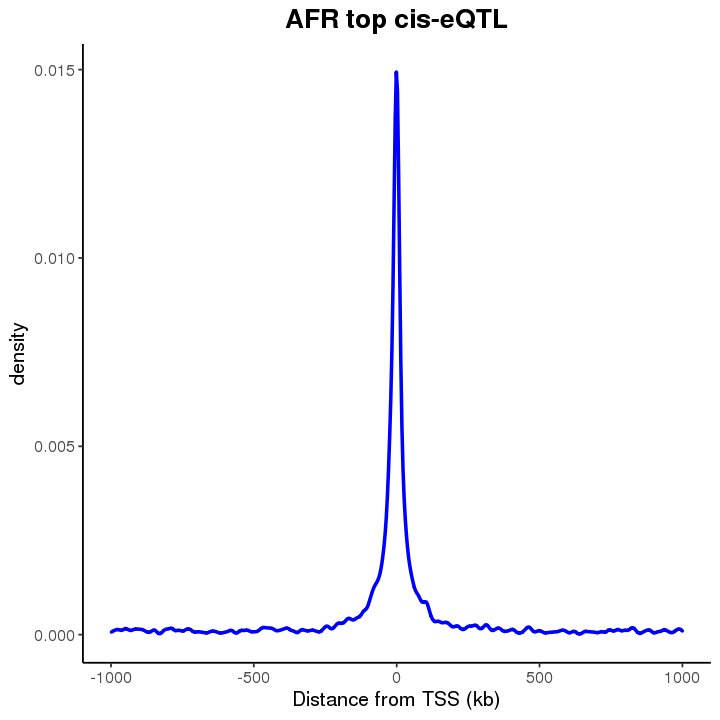

In [31]:
afr_sig <- read.table("results/afr_perm_25HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
afr_sig$dist_kb <- afr_sig$dist/1000
p3 <- ggplot(afr_sig, aes(x = dist_kb)) +
    geom_density(color = "blue", size = 1) +
    labs(x = "Distance from TSS (kb)",
         title = "AFR top cis-eQTL") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p3
ggsave("figures/afr_dist.png", p3, height = 6, width = 6)

### 5: Ancestry eGene UpsetR

In [32]:
mixed_gene <- unique(mixed_sig$pid)
eur_gene <- unique(eur_sig$pid)
amr_gene <- unique(amr_sig$pid)
afr_gene <- unique(afr_sig$pid)

In [33]:
genes <- list(Combined = mixed_gene,
            EUR = eur_gene,
            AMR = amr_gene,
            AFR = afr_gene)

In [37]:
pdf(file="figures/upsetr_egene.pdf", onefile=F)
upset(fromList(genes), order.by = "freq",
      sets.bar.color = "#56B4E9",
      empty.intersections = "on",
      sets.x.label = "Number of eGene",
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","Combined"),
                          color = "orange", active = F),
                     list(query = intersects, params = list("AFR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("AMR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("EUR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("Combined"),
                          color = "red", active = F)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.5))
dev.off()

png 
  2

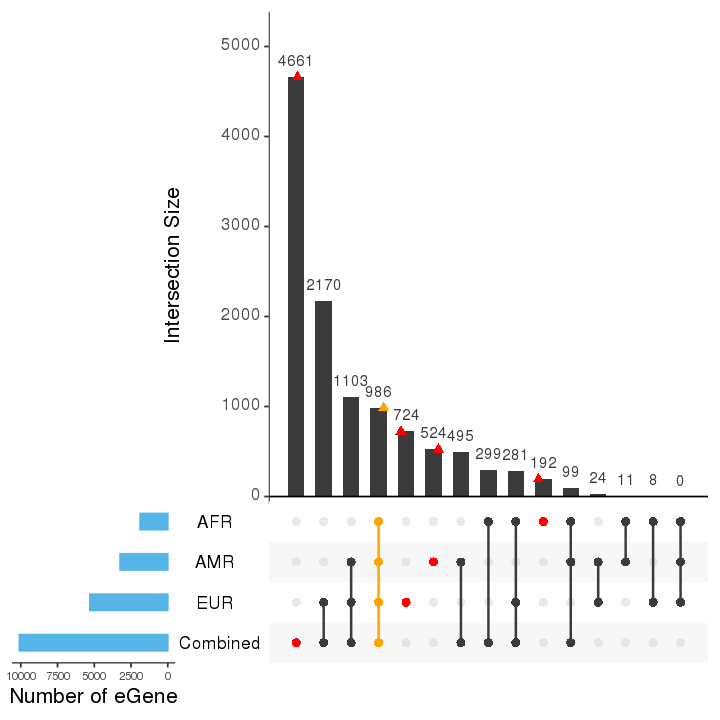

In [36]:
upset(fromList(genes), order.by = "freq",
      sets.bar.color = "#56B4E9",
      empty.intersections = "on",
      sets.x.label = "Number of eGene",
      queries = list(list(query = intersects, params = list("AFR","AMR","EUR","Combined"),
                          color = "orange", active = F),
                     list(query = intersects, params = list("AFR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("AMR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("EUR"),
                          color = "red", active = F),
                     list(query = intersects, params = list("Combined"),
                          color = "red", active = F)),
      text.scale = c(1.5, 1.5, 1.5, 1, 1.5, 1.5))

### 6: eGene venn PsychENCODE, GTEx cortex

In [10]:
mixed_egene <- unique(mixed_sig$pid)
length(mixed_egene)

[1] 10094

In [19]:
# GTEx v7 cortex 
gtex_7_egene <- read.table("~/project-gandalm/isoform_twas/gtex/v7_egene.txt", header = F ,stringsAsFactors = F)$V1

# GTEx v8 cortex
gtex_8 <- fread("~/project-gandalm/isoform_twas/gtex/GTEx_Analysis_v8_eQTL/Brain_Cortex.v8.egenes.txt.gz", data.table = F) %>% filter(qval <= 0.05) 
gtex_8_egene <- as.data.frame(unique(gtex_8$gene_id))

In [20]:
head(gtex_8_egene)

,unique(gtex_8$gene_id)
,<fct>
1,ENSG00000227232.5
2,ENSG00000241860.6
3,ENSG00000279457.4
4,ENSG00000228463.9
5,ENSG00000225972.1
6,ENSG00000225630.1


In [22]:
names(gtex_8_egene) <- c("gene.version")
gtex_8_egene <- gtex_8_egene %>% separate("gene.version", c("gene","version"), sep="[.]")
head(gtex_8_egene)

,gene,version
,<chr>,<chr>
1,ENSG00000227232,5
2,ENSG00000241860,6
3,ENSG00000279457,4
4,ENSG00000228463,9
5,ENSG00000225972,1
6,ENSG00000225630,1


In [23]:
length(gtex_7_egene)
length(gtex_8_egene$gene)

[1] 6146

[1] 9082

In [24]:
# fetal-v7
sum(mixed_egene %in% gtex_7_egene)
# fetal-v8
sum(mixed_egene %in% gtex_8_egene$gene)

[1] 3278

[1] 4607

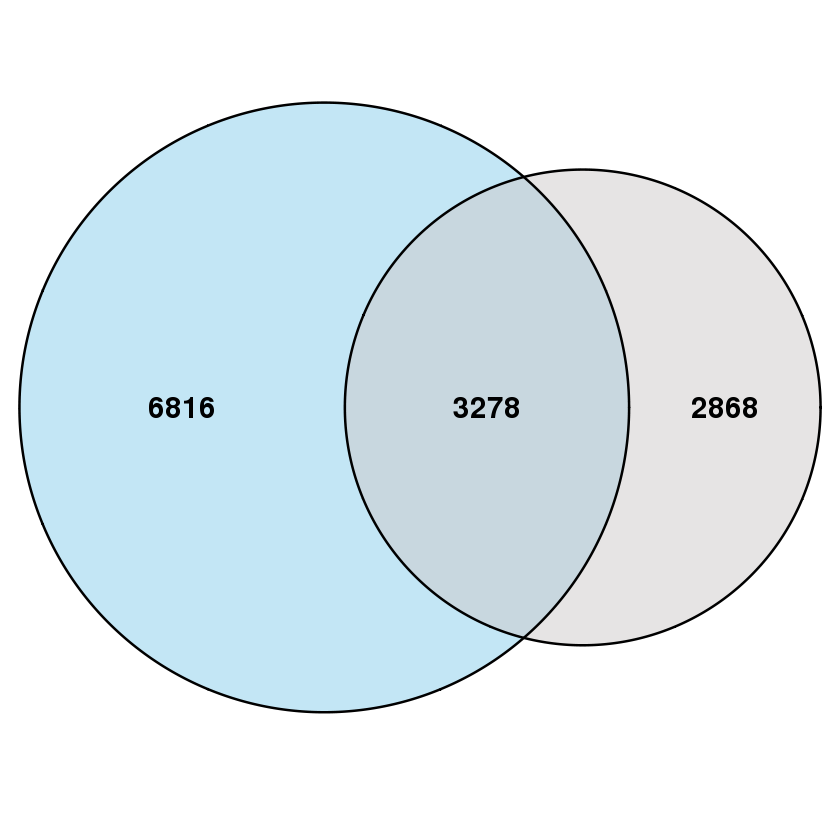

In [28]:
# fetal-v7
venn.plot <- draw.pairwise.venn(10094, 6146, 3278, fill=c("skyblue", "snow3"),
                                alpha=c(0.5,0.5), cex=1.5, fontface=2, fontfamily=rep("sans",3),
                                cat.cex=1.5,cat.fontface=2, cat.pos=c(-150,150),cat.dist=rep(.05,2),
                                cat.fontfamily=rep("sans",2), 
                                category=c("", ""))

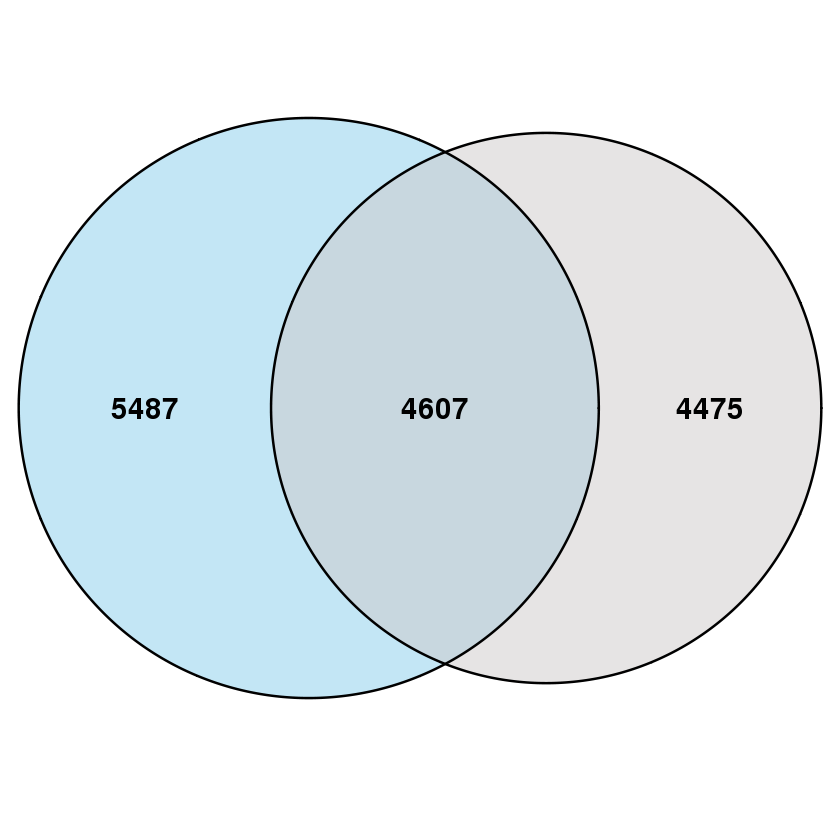

In [29]:
# fetal-v8
venn.plot <- draw.pairwise.venn(10094, 9082, 4607, fill=c("skyblue", "snow3"),
                                alpha=c(0.5,0.5), cex=1.5, fontface=2, fontfamily=rep("sans",3),
                                cat.cex=1.5,cat.fontface=2, cat.pos=c(-150,150),cat.dist=rep(.05,2),
                                cat.fontfamily=rep("sans",2), 
                                category=c("", ""))

In [30]:
# PEC nominals
pec_nominal <- fread("~/project-gandalm/isoform_twas/psychencode/DER-08a_hg19_eQTL.significant.txt", data.table = F)
head(pec_nominal)

gene_id,gene_chr,gene_start,gene_end,strand,number_of_SNPs_tested,SNP_distance_to_TSS,SNP_id,SNP_chr,SNP_start,SNP_end,nominal_pval,regression_slope,top_SNP,FDR
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>
ENSG00000215004.3,chr3,29128887,29128887,+,4558,-365581,3:28763306,chr3,28763306,28763306,0.000270335,0.0886898,1,0.01979050
ENSG00000215004.3,chr3,29128887,29128887,+,4558,-364465,3:28764422,chr3,28764422,28764422,0.000344220,0.0868007,0,0.02424459
ENSG00000215004.3,chr3,29128887,29128887,+,4558,-364376,3:28764511,chr3,28764511,28764511,0.000523559,0.0841030,0,0.03431670
ENSG00000215004.3,chr3,29128887,29128887,+,4558,-357186,3:28771701,chr3,28771701,28771701,0.000606794,0.0861309,0,0.03870841
ENSG00000215004.3,chr3,29128887,29128887,+,4558,276595,3:29405482,chr3,29405482,29405482,0.000509309,-0.5076670,0,0.03355055
ENSG00000215004.3,chr3,29128887,29128887,+,4558,753189,3:29882076,chr3,29882076,29882076,0.000525076,0.0807715,0,0.03439850


In [32]:
length(unique(pec_nominal$gene_id))

[1] 32944

In [34]:
pec_nominal_egene <- fread("~/project-gandalm/isoform_twas/psychencode/egene.txt", data.table = F)
head(pec_nominal_egene)

,egene
,<chr>
1,ENSG00000215004
2,ENSG00000144642
3,ENSG00000235904
4,ENSG00000203506
5,ENSG00000227795
6,ENSG00000235593


In [35]:
dim(pec_nominal_egene)
length(unique(pec_nominal_egene)$egene)

[1] 32945     1

[1] 32944

In [36]:
# fetal nominal
fetal_nom <- fread("results/mixed_nominal_90hcp/significant_assoc.txt", data.table = F)
head(fetal_nom)

,pid,sid,dist,npval,slope,fdr
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,ENSG00000258162,rs7299713,565454,3.46602e-04,-0.2020930,0.045061559
2,ENSG00000258375,rs6539629,666247,3.36203e-05,0.3712650,0.006459398
3,ENSG00000258375,rs7301748,669071,3.36203e-05,0.3712650,0.006459398
4,ENSG00000258375,rs113125209,673853,2.57610e-04,0.3259410,0.035603251
5,ENSG00000139220,rs12812709,295636,2.42821e-04,-0.0786925,0.033946071
6,ENSG00000127720,rs78374721,-547758,2.90007e-04,0.4310800,0.039127901


In [38]:
fetal_nom_egene <- unique(fetal_nom$pid)
length(fetal_nom_egene)
sum(fetal_nom_egene %in% pec_nominal_egene$egene)

[1] 22850

[1] 16525

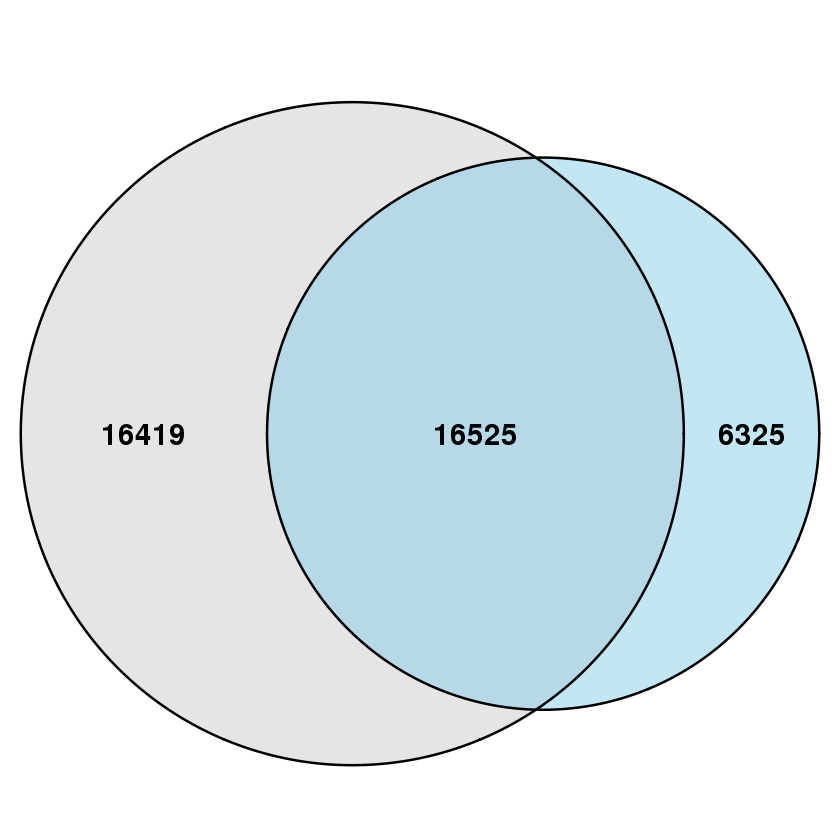

In [39]:
# fetal-pec, nominals
venn.plot <- draw.pairwise.venn(22850, 32944, 16525, fill=c("skyblue", "snow3"),
                                alpha=c(0.5,0.5), cex=1.5, fontface=2, fontfamily=rep("sans",3),
                                cat.cex=1.5,cat.fontface=2, cat.pos=c(-150,150),cat.dist=rep(.05,2),
                                cat.fontfamily=rep("sans",2), 
                                category=c("", ""))

### 7: eGene types

In [4]:
annot <- fread("~/project-gandalm/isoform_twas/salmon/gencode.v33lift37.annotation.gene.info.tsv", data.table=F)

In [11]:
mixed_sig <- mixed_sig %>% left_join(annot, by=c("pid"="ensg"))

In [12]:
dim(mixed_sig)

[1] 10094    26

In [13]:
mixed_sig <- mixed_sig[,c(1:14, 25, 26)]

In [15]:
colnames(mixed_sig)[15] <- "gene_type"
colnames(mixed_sig)[16] <- "gene_name"
head(mixed_sig)

,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold,dist_kb,gene_type,gene_name
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,ENSG00000000419,6979,1.02134,1367.680,476.819,rs192563417,785096,1.36171e-07,-0.505097,0.00079992,6.71442e-04,1.47123e-03,2.90212e-05,785.096,protein_coding,DPM1
2,ENSG00000000460,7370,1.03366,743.049,467.386,rs17529513,167500,1.08049e-22,-0.302487,0.00009999,6.83032e-18,5.86726e-17,5.58582e-05,167.500,protein_coding,C1orf112
3,ENSG00000001036,5683,1.04787,948.786,469.456,rs4896658,-47658,1.77472e-07,-0.588128,0.00069993,5.90912e-04,1.30931e-03,4.60076e-05,-47.658,protein_coding,FUCA2
4,ENSG00000001460,5648,1.04183,862.516,466.170,rs760969,2280,1.34110e-62,-0.657378,0.00009999,1.67187e-54,8.74000e-53,4.95438e-05,2.280,protein_coding,STPG1
5,ENSG00000001461,5648,1.04028,804.007,459.959,rs497071,-28459,3.82613e-21,-0.304292,0.00009999,2.93508e-16,2.26687e-15,5.28578e-05,-28.459,protein_coding,NIPAL3
6,ENSG00000001561,5517,1.03939,749.126,465.199,rs34269469,20326,1.39239e-12,0.129466,0.00009999,1.17992e-08,4.79713e-08,5.65509e-05,20.326,protein_coding,ENPP4


In [59]:
write.table(mixed_sig, "results/mixed_perm_90hcp/sig_pheno_info.txt", col.names=T, row.names=F, quote=F, sep="\t")

In [30]:
df <- as.data.frame(sort(table(mixed_sig$gene_type)))
df <- df[order(df$Freq, decreasing = TRUE),]
df <- df[c(1:4),]
df$Var1 <- as.character(df$Var1)
df[5,] <- c("Other", (10094-6278-2448-378-244))
df <- df %>% mutate(prop = as.numeric(Freq)/10094)
df

Var1,Freq,prop
<chr>,<chr>,<dbl>
protein_coding,6278,0.62195364
lncRNA,2448,0.24252031
processed_pseudogene,378,0.03744799
transcribed_unprocessed_pseudogene,244,0.02417278
Other,746,0.07390529


In [31]:
df$Var1 <- factor(df$Var1, levels = c("protein_coding", "lncRNA", "processed_pseudogene", "transcribed_unprocessed_pseudogene", "Other"))

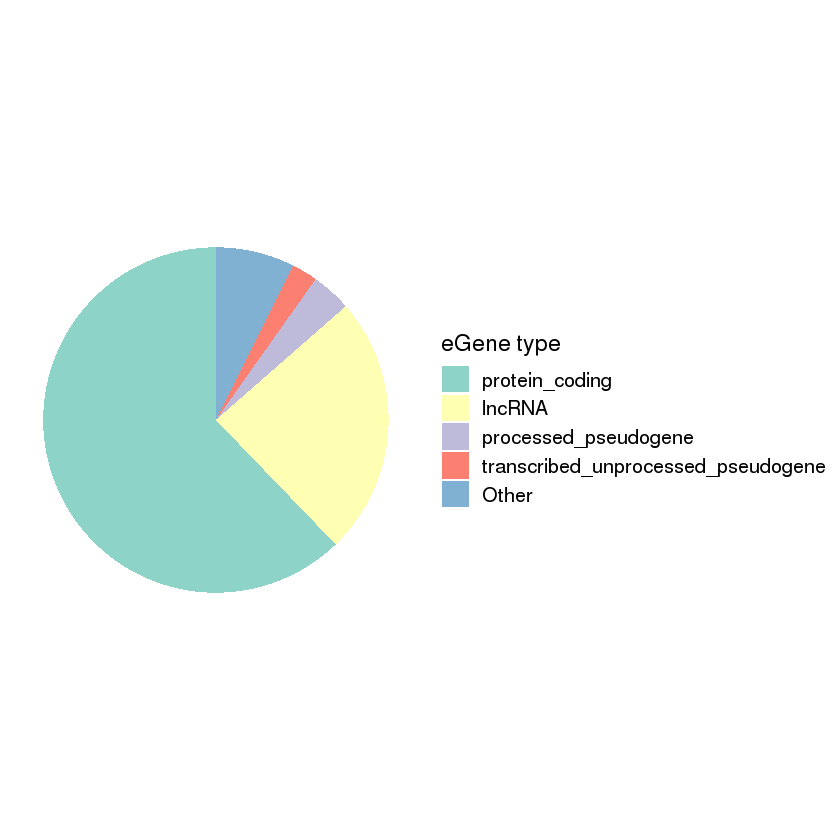

In [32]:
p <- ggplot(df, aes(x="", y=prop, fill=Var1)) +
  geom_bar(width = 1, stat = "identity") +
  coord_polar("y", start = 0) +
  theme_void() +
  theme(legend.text = element_text(size=12),
        legend.title = element_text(size=14)) +
  scale_fill_brewer(palette = "Set3") +
  labs(fill="eGene type")

p 

### 8: Conditional cis-eQTL

** Top variants per rank of all expressed genes **

In [5]:
dat <- fread("results/mixed_conditional_90hcp/conditional_top_variants.txt", data.table = F)

In [6]:
head(dat)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,ENSG00000225231,12,10096094,10096094,+,5720,-8,rs74065411,12,10096086,10096086,0,3.07451e-92,1.843920,1,1,1.72174e-48,1.245000,1,1
2,ENSG00000225231,12,10096094,10096094,+,5720,26397,rs117342025,12,10122491,10122491,1,1.48906e-06,1.247380,0,1,5.24278e-06,1.181680,1,1
3,ENSG00000225231,12,10096094,10096094,+,5720,74067,rs1054611,12,10170161,10170161,2,1.26199e-05,-0.238055,1,1,2.18747e-05,-0.231514,1,1
4,ENSG00000225231,12,10096094,10096094,+,5720,420204,chr12:10363699,12,10516298,10516302,3,1.97689e-05,-1.042710,1,1,2.34256e-06,-1.151750,1,1
5,ENSG00000225231,12,10096094,10096094,+,5720,664530,rs10845180,12,10760624,10760624,4,5.37902e-05,-0.251489,1,1,5.37902e-05,-0.251489,1,1
6,ENSG00000173391,12,10324737,10324737,+,6210,-14018,rs34874375,12,10310719,10310719,0,9.87270e-08,-0.112123,1,1,9.87270e-08,-0.112123,1,1


In [7]:
table(dat$V19)
table(dat$V20)


    1 
17318 


    0     1 
   79 17239 

In [10]:
# subset eGenes only
# egene_dat <- read.table("results/mixed_perm_90hcp/sig_pheno.txt",hea = T, stringsAsFactors = F)

** remove variants with backward P-value that is not below the threshold of this feature **

In [8]:
dat <- dat %>% filter(V20 == 1)

** check features with significant conditional QTL are mostly isoforms with permutation isoQTL **

In [10]:
length(unique(mixed_sig$pid))
length(unique(dat$V1))
sum(unique(mixed_sig$pid) %in% unique(dat$V1))

[1] 10094

[1] 11574

[1] 9583

**How many ranks/independent QTL each feature has? (+1 because primary QTL is rank 0)**

In [11]:
table(dat$V12)


    0     1     2     3     4     5     6     7     8     9 
11451  3826  1278   450   165    49    15     3     1     1 

In [14]:
dat %>% filter(V12 == 8)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
ENSG00000197728,12,56435135,56435135,+,4914,-46246,chr12:55995105,12,56388889,56388889,8,2.12e-05,-0.380745,1,1,5.67807e-06,-0.405966,1,1


In [15]:
dat %>% filter(V1 == "ENSG00000197728")

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
ENSG00000197728,12,56435135,56435135,+,4914,13065,rs76550017,12,56448200,56448200,0,3.84520e-02,0.119829,0,0,2.77126e-12,0.590650,1,1
ENSG00000197728,12,56435135,56435135,+,4914,10231,rs10876866,12,56445366,56445366,1,1.43286e-19,0.577330,1,1,4.42879e-08,0.356344,1,1
ENSG00000197728,12,56435135,56435135,+,4914,36578,chr12:56077929,12,56471713,56471713,2,1.76148e-14,0.869672,1,1,1.20850e-16,0.935859,1,1
ENSG00000197728,12,56435135,56435135,+,4914,-626204,rs11171454,12,55808931,55808931,3,9.41843e-05,0.273803,0,0,4.26096e-05,0.286796,1,1
ENSG00000197728,12,56435135,56435135,+,4914,45513,rs705696,12,56480648,56480648,4,3.77088e-02,0.135927,0,0,3.51449e-05,0.269253,1,1
ENSG00000197728,12,56435135,56435135,+,4914,45513,rs705696,12,56480648,56480648,5,2.27803e-08,0.361728,1,1,7.08283e-09,0.374303,1,1
ENSG00000197728,12,56435135,56435135,+,4914,10545,rs71459336,12,56445680,56445680,7,1.24585e-05,0.433959,1,1,7.39264e-07,0.490641,1,1
ENSG00000197728,12,56435135,56435135,+,4914,-46246,chr12:55995105,12,56388889,56388889,8,2.12000e-05,-0.380745,1,1,5.67807e-06,-0.405966,1,1
ENSG00000197728,12,56435135,56435135,+,4914,-67169,rs80223410,12,56367966,56367966,9,2.09500e-05,-0.392605,1,1,2.09500e-05,-0.392605,1,1


In [17]:
df %>% filter(gene == "ENSG00000197728")

gene,num_rank
<fct>,<dbl>
ENSG00000197728,10


In [13]:
table(df$num_rank)


   1    2    3    4    5    6    7    8   10 
7745 2546  833  284  117   33   13    2    1 

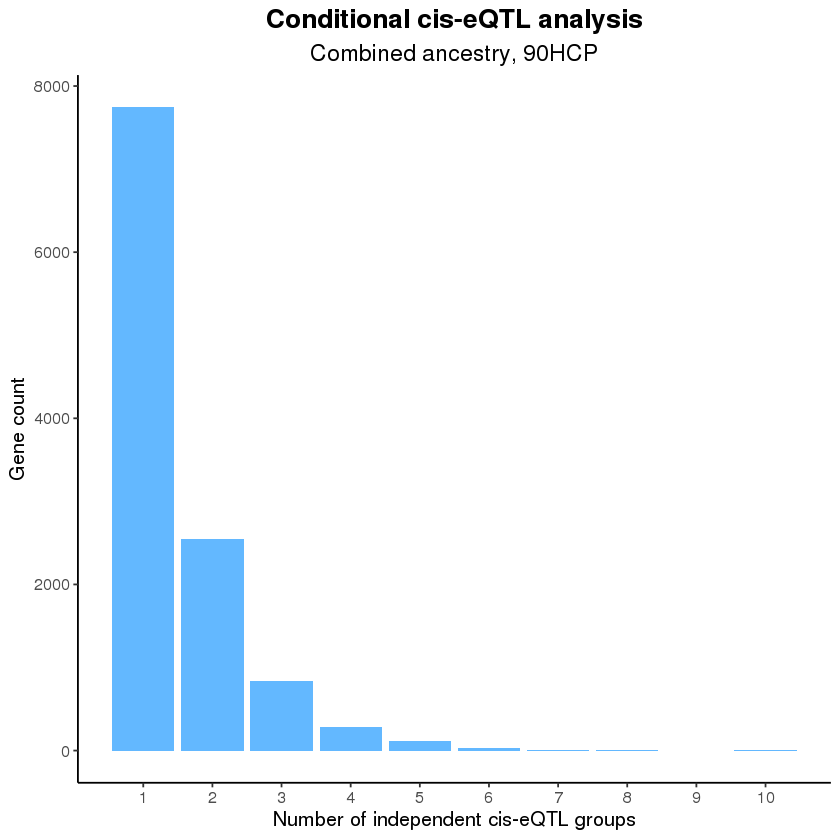

In [18]:
df <- data.frame("gene" <- unique(dat$V1),
                 "num_rank" <- NA)
for (i in 1:nrow(df)) {
  gene <- df[i,1]
  df[i,2] <- max(dat[dat$V1==gene,12]) + 1
}
names(df) <-c("gene","num_rank")

p <- ggplot(df, aes(x=num_rank)) +
  geom_bar(fill="steelblue1") +
  scale_x_continuous(breaks = seq(1,10,by=1)) +
  labs(x="Number of independent cis-eQTL groups", y="Gene count") +
  ggtitle("Conditional cis-eQTL analysis", subtitle = "Combined ancestry, 90HCP") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust=0.5),
        plot.subtitle = element_text(size=14, hjust=0.5))
p

In [19]:
ggsave("figures/condition_rank.png", p, height=6, width=6)

**Primary and seconday distance to TSS**

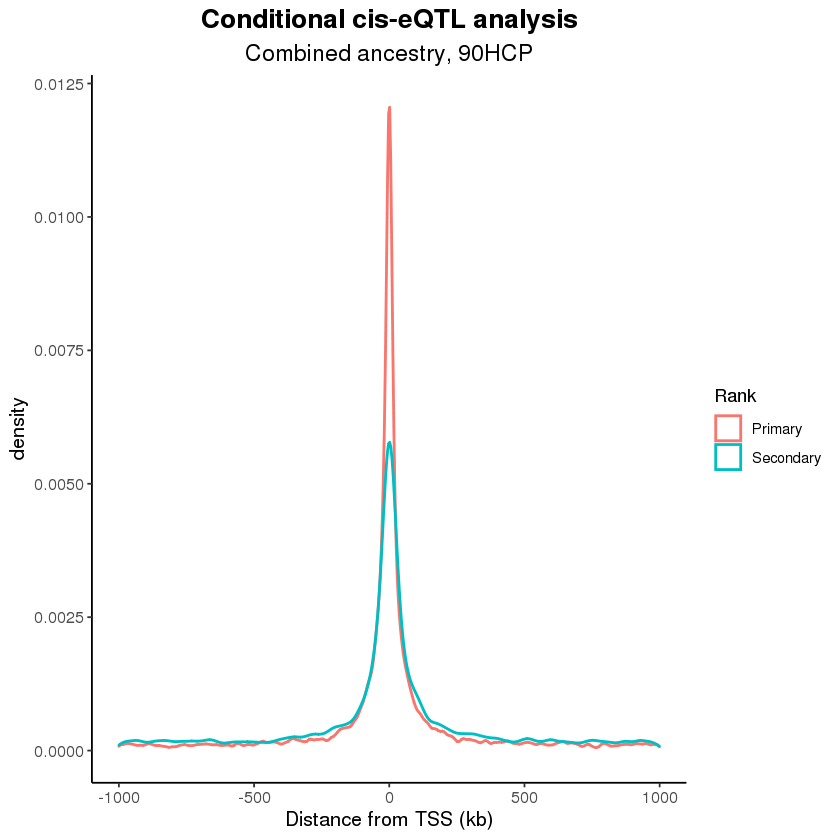

In [5]:
dat2 <- filter(dat,V12 <= 1)
dat2$tss_kb <- dat2$V7/1000

dat2$Rank <- ifelse(dat2$V12==0,"Primary","Secondary")

p2 <- ggplot(dat2, aes(x=tss_kb, color=Rank)) +
  geom_density(size=.8) +
  labs(x="Distance from TSS (kb)") +
  ggtitle("Conditional cis-eQTL analysis", subtitle = "Combined ancestry, 90HCP") +
  theme_classic() +
  theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust=0.5),
        plot.subtitle = element_text(size=14, hjust=0.5))
p2

In [49]:
ggsave("figures/condition_dtss.png", p2, height=6, width=6)

In [35]:
head(dat2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V13,V14,V15,V16,V17,V18,V19,V20,tss_kb,Rank
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>
1,ENSG00000225231,12,10096094,10096094,+,5720,-8,rs74065411,12,10096086,⋯,3.07451e-92,1.8439200,1,1,1.72174e-48,1.2450000,1,1,-0.008,Primary
2,ENSG00000225231,12,10096094,10096094,+,5720,26397,rs117342025,12,10122491,⋯,1.48906e-06,1.2473800,0,1,5.24278e-06,1.1816800,1,1,26.397,Secondary
3,ENSG00000173391,12,10324737,10324737,+,6210,-14018,rs34874375,12,10310719,⋯,9.87270e-08,-0.1121230,1,1,9.87270e-08,-0.1121230,1,1,-14.018,Primary
4,ENSG00000139112,12,10365057,10365057,+,6295,3950,rs11053689,12,10369007,⋯,1.02264e-06,0.0466216,1,1,1.02264e-06,0.0466216,1,1,3.950,Primary
5,ENSG00000213809,12,10544473,10544473,+,6054,166841,rs11836592,12,10711314,⋯,1.58243e-09,0.1884360,1,1,1.58243e-09,0.1884360,1,1,166.841,Primary
6,ENSG00000183542,12,10562356,10562356,+,6074,98097,rs7963827,12,10660453,⋯,1.15193e-05,0.1779280,1,1,1.15193e-05,0.1779280,1,1,98.097,Primary


In [36]:
table(dat2$Rank)


  Primary Secondary 
    11451      3826 

In [6]:
primary <- dat2 %>% filter(Rank == "Primary")
secondary <- dat2 %>% filter(Rank == "Secondary")

In [7]:
median(primary$tss_kb)
median(secondary$tss_kb)

[1] -0.046

[1] 0.443

** wilcox test on TSS absolute values**

In [8]:
wilcox.test(abs(primary$tss_kb), abs(secondary$tss_kb), alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  abs(primary$tss_kb) and abs(secondary$tss_kb)
W = 18212726, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [9]:
df <- data.frame("Group"=c(rep("Primary", 11451), rep("Secondary", 3826)),
                "TSS_kb"=c(primary$tss_kb, secondary$tss_kb))

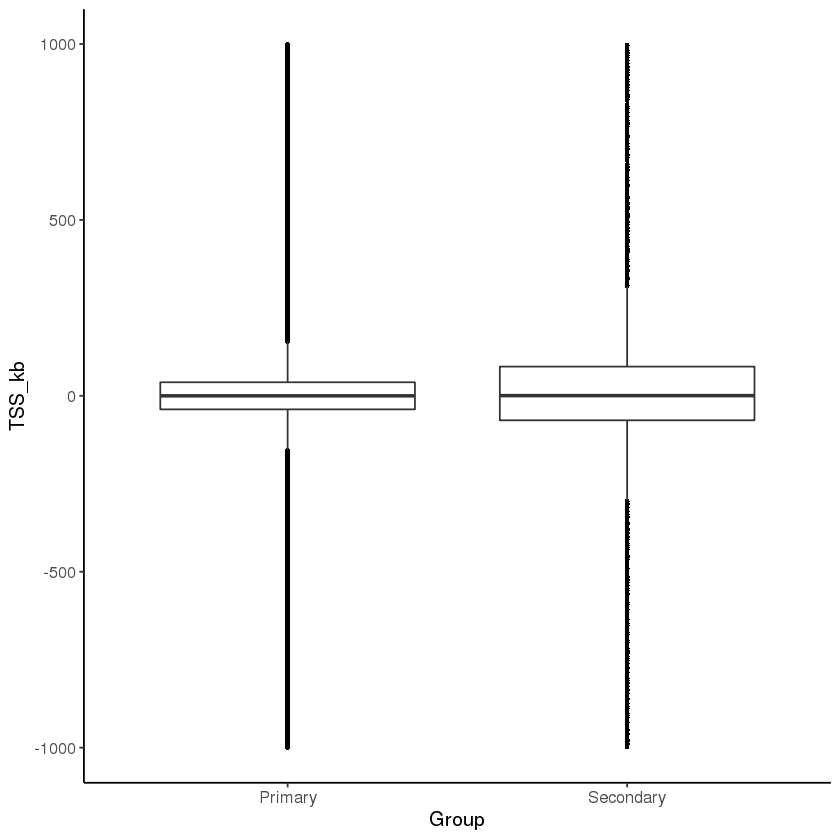

In [10]:
ggplot(df, aes(x=Group, y=TSS_kb)) +
    geom_boxplot(outlier.colour = "black", outlier.shape = 16, outlier.size = 1) +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust=0.5),
        plot.subtitle = element_text(size=14, hjust=0.5))